* To investigate the difference of flux, salt, and freshwater between two bathymetries.

In [1]:
import numpy as np
import netCDF4 as nc
from salishsea_tools import (nc_tools,viz_tools,tidetools,geo_tools)
import datetime, os
from glob import glob
from nowcast import figures
import matplotlib.pyplot as plt
from R_mixStuff import sites
from R_mixStuff import strings
import warnings
warnings.filterwarnings("ignore")
import seaborn as sns
%matplotlib inline
sns.set(style="whitegrid")
sns.set_context("notebook", font_scale=2, rc={"lines.linewidth": 2.5})

In [24]:
transects = {'1':{'jst':55, 'ist':25,'jen':56,'ien':80},
            '2':{'jst':25, 'ist':25,'jen':26,'ien':75},
            '3':{'jst':25, 'ist':25,'jen':56,'ien':26},
            '4':{'jst':37, 'ist':72,'jen':45,'ien':73},
            '5':{'jst':120, 'ist':138,'jen':121,'ien':139},
            '6':{'jst':96,'ist':125,'jen':97,'ien':126},
            '7':{'jst':36,'ist':98,'jen':37,'ien':99},
            '8':{'jst':34,'ist': 90,'jen':37,'ien':91}}
grid6 = nc.Dataset('/ocean/jieliu/research/meopar/river-treatment/bathy_meter_SalishSea6.nc')
grid2 = nc.Dataset('/ocean/jieliu/research/meopar/nemo-forcing/grid/bathy_meter_SalishSea2.nc')
X = grid6.variables['nav_lon'][380:510,240:397]
Y = grid6.variables['nav_lat'][380:510,240:397]
bathy = grid6.variables['Bathymetry'][380:510,240:397]
bathy2 = grid2.variables['Bathymetry'][380:510,240:397]

In [3]:
## mask
mesh = nc.Dataset('/data/jieliu/MEOPAR/river-treatment/oct8_101e061e05/mesh_mask.nc')
tmask = mesh.variables['tmask'][0,:,380:510,240:397]
umask = mesh.variables['umask'][0,:,380:510,240:397]
vmask = mesh.variables['vmask'][0,:,380:510,240:397]
e3u = mesh.variables['e3u'][0,:,380:510,240:397]
e3v = mesh.variables['e3v'][0,:,380:510,240:397]
e3t = mesh.variables['e3t'][0,:,380:510,240:397]
e2t = mesh.variables['e2t'][0,380:510,240:397]
e1t = mesh.variables['e1t'][0,380:510,240:397]
np_mask = np.abs(1-tmask) 

(48.95, 49.2)

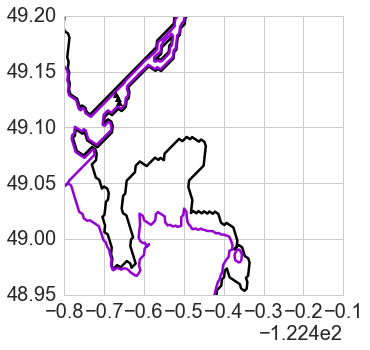

In [4]:
fig, ax = plt.subplots(1,1,figsize = (5,5))
viz_tools.plot_coastline(ax, grid6, coords = 'map')
viz_tools.plot_coastline(ax, grid6, coords = 'map', isobath = 5,color = 'DarkViolet')
#ax.plot(X[55,25:80],Y[55,25:80],'r^')
#ax.plot(X[25,25:75],Y[25,25:75],'b^')
#ax.plot(X[25:56,25],Y[25:56,25],'g^')
#ax.plot(X[37:45,72],Y[37:45,72],'y^')
ax.plot(X[34:37,90],Y[34:37,90],'k^')
#ax.plot(X[120:121,138],Y[120:121,138],'k^')
#ax.annotate ('transect 1',(X[55,50],Y[55,50]), xycoords="data",color = 'r')
#ax.annotate ('transect 2',(X[25,50],Y[25,50]), xycoords="data",color = 'b')
#ax.annotate ('transect 3',(X[40,25],Y[40,25]), xycoords="data",color = 'g')
#ax.annotate ('transect 4',(X[25,70],Y[25,70]), xycoords="data",color = 'y')
ax.set_xlim([-123.2,-122.5])
ax.set_ylim([48.95,49.2])

In [5]:
## load salinity into a dict
paths = ['Oct2014OnlyRiver','Oct2014OnlyRiverBathy2','Oct2014nowind','Oct2014nowindBathy2']
base='/data/jieliu/MEOPAR/SurfaceCurrent/'
file_patternT = 'oct2014*_T.nc'
file_patternU = 'oct2014*_U.nc'
file_patternV = 'oct2014*_V.nc'
U = {}; V={}; S={};ssh = {}
for pa in paths:
    pathT = glob(os.path.join(base,pa, file_patternT))
    pathU = glob(os.path.join(base,pa, file_patternU))
    pathV = glob(os.path.join(base,pa, file_patternV))
    fU = nc.Dataset(pathU[0],'r');
    U[pa] = fU.variables['vozocrtx']
    fV = nc.Dataset(pathV[0],'r');
    V[pa] = fV.variables['vomecrty']
    depU = fU.variables['depthu']
    depV = fV.variables['depthv']
    fT = nc.Dataset(pathT[0],'r');
    S[pa] = fT.variables['vosaline']
    lon = fT.variables['nav_lon'] 
    lat = fT.variables['nav_lat']
    ssh[pa] = fT.variables['sossheig']
    time_counter = fT.variables['time_counter']

In [6]:
def transport_calculate(S,U,V,ssh,lon,lat,depU,depV,tran,t_st,t_en,S0,fresh_flag = 'fresh',\
                                y0lim =6e5, y1lim = 6000):
    """Same as transport_calculate function, but focus on a continous time period rather 
    than a specific time, including fresh water flux 'fresh' flag,
    salt flux 'salt' flag, and total flux 'None' flag"""
    UU = {}; VV= {};SS={}
    jinds = np.arange(transects[tran]['jst'],transects[tran]['jen']+1)
    iinds = np.arange(transects[tran]['ist'],transects[tran]['ien']+1)
    for pa in paths:
        SS[pa] = np.zeros([time_counter.shape[0],depU.shape[0],jinds.shape[0],iinds.shape[0]])
        UU[pa] = np.zeros([time_counter.shape[0],depU.shape[0],jinds.shape[0]-1,iinds.shape[0]-1])
        VV[pa] = np.zeros([time_counter.shape[0],depV.shape[0],jinds.shape[0]-1,iinds.shape[0]-1])
        for t in np.arange(t_st,t_en+1):
            SS[pa][t] = S[pa][t,:,jinds,iinds]    
            mask=np_mask[:,jinds[0]:jinds[-1]+1,iinds[0]:iinds[-1]+1]
            SS[pa][t] = np.ma.masked_array(SS[pa][t],mask=mask) ## mask sal=0 by tmask 
                    
            if tran == '5' or tran =='7': ##single grid T cell
                u = np.add(U[pa][t,:,jinds[0],iinds][..., :-1], U[pa][t,:,jinds[0],iinds][..., 1:]) / 2
                VV[pa][t]=0
                UU[pa][t] = u.reshape(depU.shape[0],1,1)
            elif tran == '6': ## single grid T cell
                UU[pa][t] =0
                v =np.add(V[pa][t,:,jinds,iinds[0]][..., :-1], V[pa][t,:,jinds,iinds[0]][..., 1:]) / 2
                VV[pa][t] = v.reshape(depV.shape[0],1,1)
            else:
                UU[pa][t],VV[pa][t] = viz_tools.unstagger(U[pa][t,:,jinds,iinds],\
                                          V[pa][t,:,jinds,iinds])

    trans,trans_sur,trans_to= transport_time(SS,UU,VV,ssh,lon,lat,depU,depV,tran,t_st,t_en,\
                                                S0,fresh_flag = fresh_flag) ## get surface/total transport
        ## location
    return trans,trans_sur,trans_to

In [7]:
def transport_time(S,U,V,ssh,lon,lat,depU,depV,tran,t_st,t_en,S0,fresh_flag = 'fresh'):
    """This function was made to calculate total 
    transport/fresh water transport during a continuous 
    period, rather than the specific time 
    fresh_flag = 'fresh', fresh flux; 'salt',salt flux; 'None', total flux"""
    trans = {}; trans_surf = {}; trans_total ={}
    if tran =='3' or tran =='4' or tran =='5' or tran =='7' or tran=='8': ## cross-shelf transport
        for pa in paths:
            trans[pa] = np.zeros([time_counter.shape[0],depU.shape[0],np.arange(transects[tran]['jen']-transects[tran]['jst']).shape[0]])
            for t in np.arange(t_st,t_en+1):
                for z in np.arange(depU.shape[0]):
                    for j in np.arange(transects[tran]['jen']-transects[tran]['jst']):
                        d = e2t[j+transects[tran]['jst'],transects[tran]['ist']]
                        if fresh_flag == 'None':
                            ratio = 1
                        elif fresh_flag =='salt' or fresh_flag =='saltNoV':
                            ratio = S[pa][t][z,j,0]
                        elif fresh_flag =='fresh':
                            ratio = (S0 - S[pa][t][z,j,0])/S0
                        adj_ssh = 1+ssh[pa][t,j+transects[tran]['jst'],transects[tran]['ist']]\
                        /np.sum(e3t[:,j+transects[tran]['jst'],\
                        transects[tran]['ist']]*tmask[:,j+transects[tran]['jst'],transects[tran]['ist']])
                        if fresh_flag =='saltNoV':
                            trans[pa][t,z,j] = d*e3t[z,j+transects[tran]['jst'],transects[tran]['ist']]*adj_ssh*ratio
                        else:
                            trans[pa][t,z,j] = U[pa][t,z,j,0]*d*e3t[z,j+transects[tran]['jst'],transects[tran]['ist']]*adj_ssh*ratio
    else: ## along-shore transport
        for pa in paths:
            trans[pa]= np.zeros([time_counter.shape[0],depV.shape[0],np.arange(transects[tran]['ien']-transects[tran]['ist']).shape[0]]);
            for t in np.arange(t_st,t_en+1):
                for z in np.arange(depV.shape[0]):
                    for i in np.arange(transects[tran]['ien']-transects[tran]['ist']):
                        d = e1t[transects[tran]['jst'],i+transects[tran]['ist']]
                        if fresh_flag == 'None':
                            ratio = 1
                        elif fresh_flag =='salt' or fresh_flag =='saltNoV':
                            ratio = S[pa][t][z,0,i]
                        elif fresh_flag =='fresh':
                            ratio = (S0 - S[pa][t][z,0,i])/S0

                        adj_ssh = 1+ssh[pa][t,transects[tran]['jst'],i+transects[tran]['ist']]\
                        /np.sum(e3t[:,transects[tran]['jst'],i+transects[tran]['ist']]*tmask[:,transects[tran]['jst'],i+transects[tran]['ist']])
                        if fresh_flag =='saltNoV':
                            trans[pa][t,z,i] = d*e3t[z,transects[tran]['jst'],i+transects[tran]['ist']]*adj_ssh*ratio ## shape of [40,54]
                        else:
                            trans[pa][t,z,i] = V[pa][t,z,0,i]*d*e3t[z,transects[tran]['jst'],i+transects[tran]['ist']]*adj_ssh*ratio ## shape of [40,54]
    ## surface and total transport in the dict
    for pa in paths:
        trans_surf[pa] = np.nansum(trans[pa][t_st:t_en+1,0,:],axis = 1)
        trans_total[pa] = np.nansum(np.nansum(trans[pa][t_st:t_en+1],axis = 1),axis = 1)
 
    return trans, trans_surf,trans_total

In [8]:
def plot_series_transportDaily(S,U,V,ssh,lon,lat,depU,depV,tran,tst,ten,S0,fresh_flag = 'fresh'):
    """This function is the same with plot_series_transport, except 
    that this is not integral over several days, but only for 
    daily case."""
    trans,trans_surf,trans_to = transport_calculate(S,U,V,ssh,lon,lat,depU,depV,tran,tst,ten,\
                                                                 S0,fresh_flag = fresh_flag)
    inte_trans = {}; types = ['Oct2014nowind','Oct2014nowindBathy2']
    for ty in types:
        inte_trans[ty] = np.zeros((ten+1)/24)
    for i in np.arange(tst,ten+1,24):
        for ty in types:
            inte_trans[ty][i/24] = np.sum(trans_to[ty][i:i+24])*3600## intergral individual daily
    fig, axs = plt.subplots(2,1,figsize = (20,9))
    ax = axs[0] ## ssh
    for ty in types:
        ax.plot(ssh[ty][tst:ten+1,86,89],label = ty)
    ax.set_ylabel('ssh at PA [m]')
    ax.set_xlabel('hour')
    ax = axs[1] ## total volumn flux,salt flux and freshwater flux for selected run case and obs
    filename = '/data/dlatorne/SOG-projects/SOG-forcing/ECget/Fraser_flow'
    fraserflow = np.loadtxt(filename)
    real_flows = np.zeros((ten+1)/24);
    for t in np.arange((ten+1)/24): ## default tst -0, from start
        real_flows[t] = -fraserflow[348+t][-1]*24*3600
    for ty in types:
        ax.plot(inte_trans[ty],'.',label = ty,markersize = 10)
        ax.set_ylabel('Flux $m^3$')    
        ax.set_xlim([(tst-24)/24,(ten+1)/24])
    ax.plot(real_flows,'*',label = 'real',markersize = 10)
    ax.legend(loc = 'best')
    ax.set_xlabel('Day')

In [9]:
def plot_series_transport(S,U,V,ssh,lon,lat,depU,depV,tran,tst,ten,S0,fresh_flag = 'fresh'):
    """Plot the transport time series in hourly results"""
    trans,trans_surf,trans_to = transport_calculate(S,U,V,ssh,lon,lat,depU,depV,tran,tst,ten,\
                                                                 S0,fresh_flag = fresh_flag)
    inte_trans = {}; types = ['Oct2014nowind','Oct2014nowindBathy2']
    fig, axs = plt.subplots(2,1,figsize = (20,9))
    ax = axs[0] ## ssh
    for ty in types:
        ax.plot(ssh[ty][tst:ten+1,86,89],label = ty)
    ax.set_ylabel('ssh at PA [m]')
    ax.set_xlabel('hour')
    ax = axs[1] ## total volumn flux,salt flux and freshwater flux for selected run case and obs
    for ty in types:
        ax.plot(trans_to[ty],'-',marker = '.',label = ty,markersize = 10)
        if fresh_flag =='saltNoV':
            ax.set_ylabel('Salinity integral $m^2$')
        else:
            ax.set_ylabel('Flux $m^3/s$')    
    ax.legend(loc = 'best')
    ax.set_xlabel('hour')

# Check salinity, salt flux and total volume flux close to the original river source

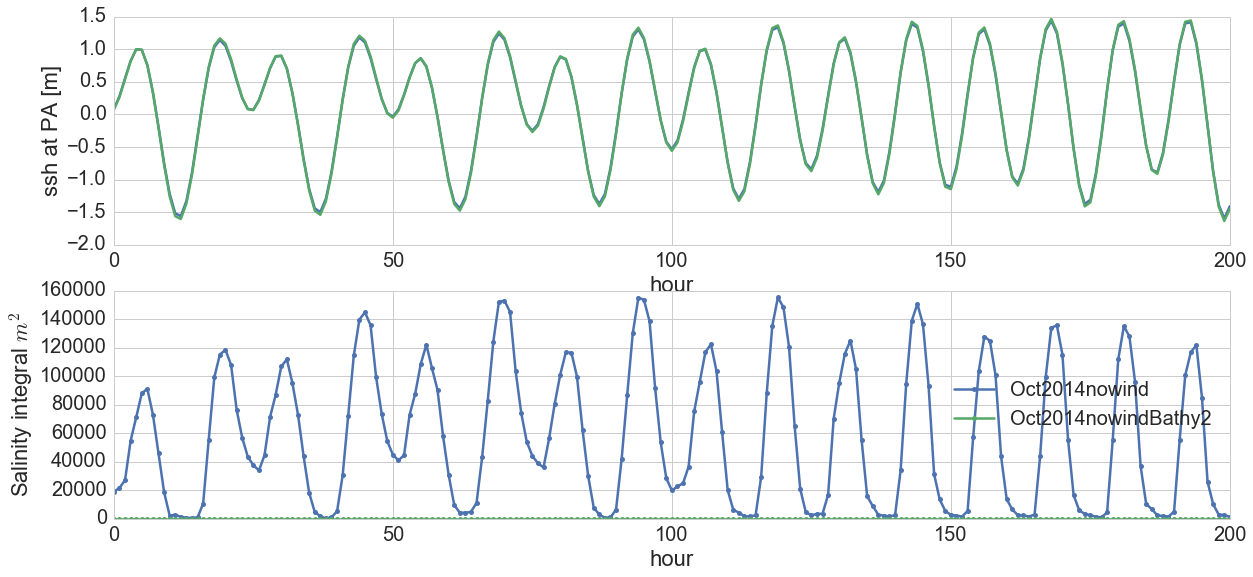

In [10]:
plot_series_transport(S,U,V,ssh,lon,lat,depU,depV,'8',0,200,30,fresh_flag='saltNoV')

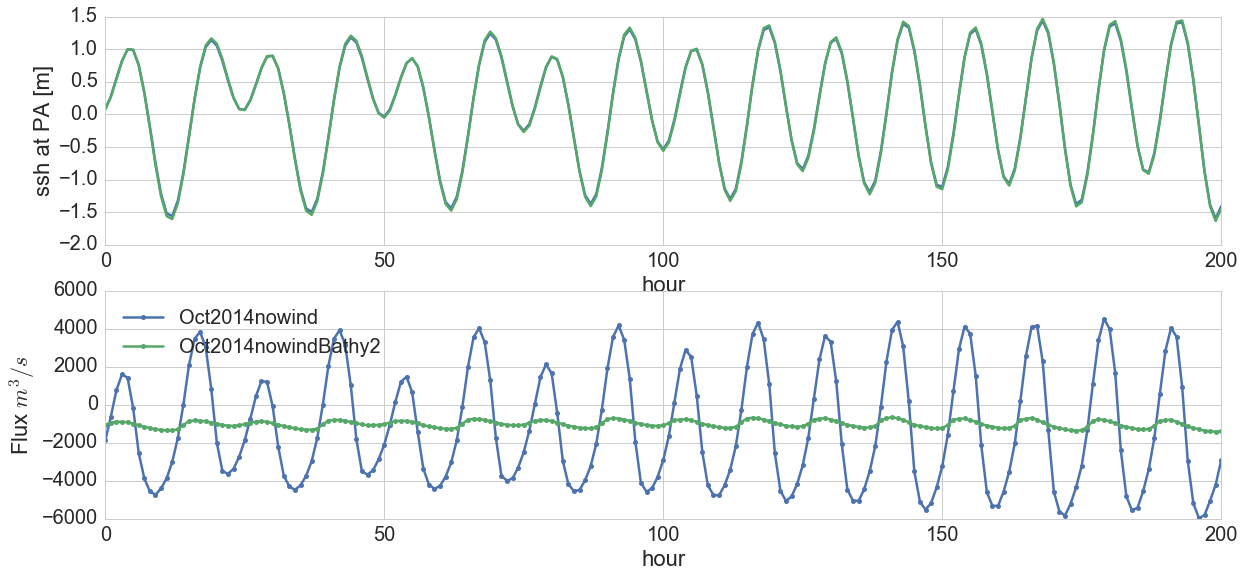

In [11]:
plot_series_transport(S,U,V,ssh,lon,lat,depU,depV,'8',0,200,30,fresh_flag='None')

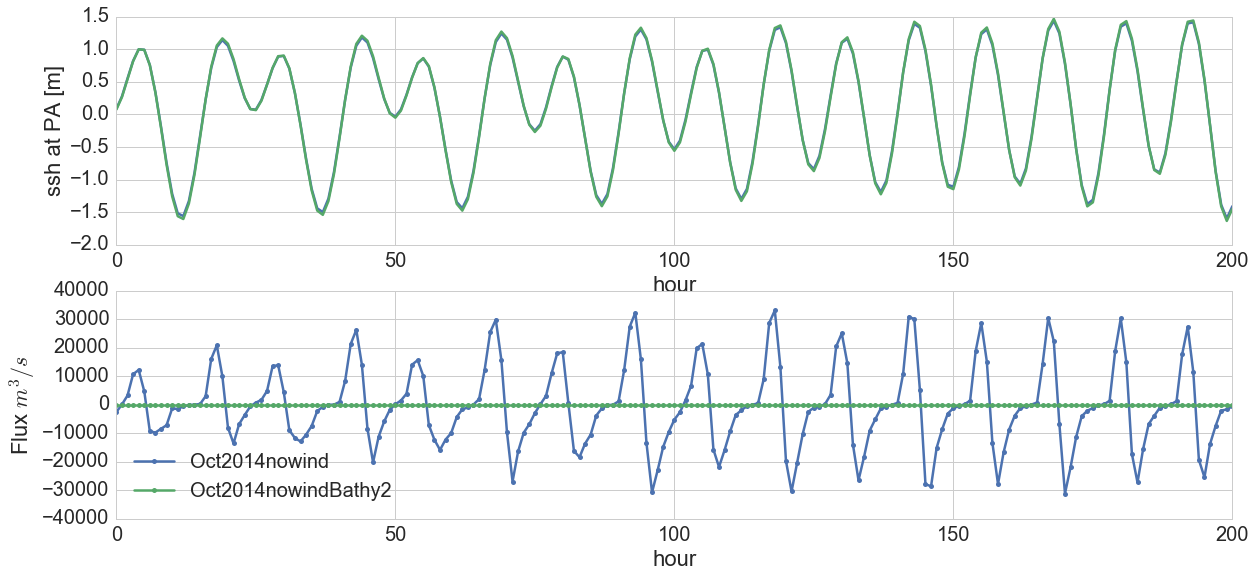

In [12]:
plot_series_transport(S,U,V,ssh,lon,lat,depU,depV,'8',0,200,30,fresh_flag='salt')

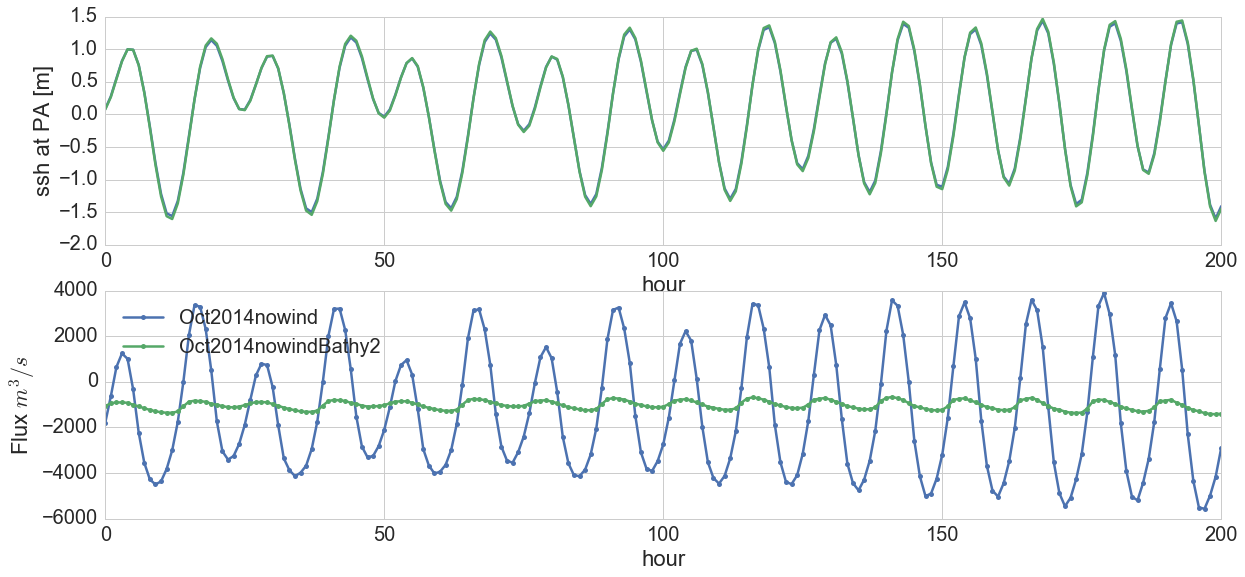

In [37]:
plot_series_transport(S,U,V,ssh,lon,lat,depU,depV,'8',0,200,30,fresh_flag='fresh')

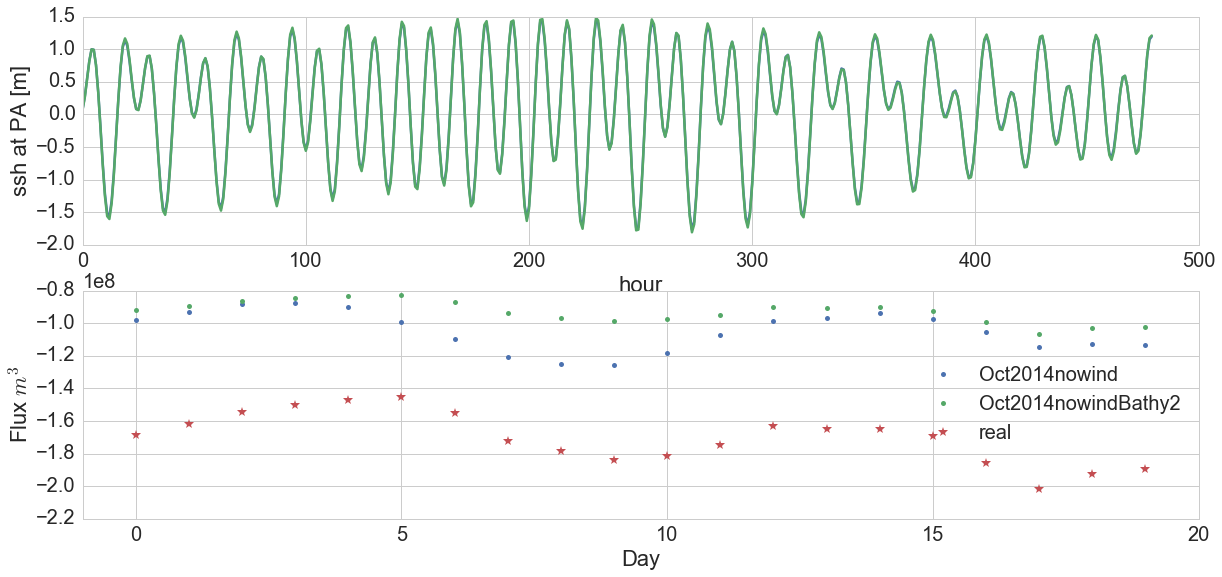

In [14]:
plot_series_transportDaily(S,U,V,ssh,lon,lat,depU,depV,'8',0,479,30,fresh_flag='fresh')

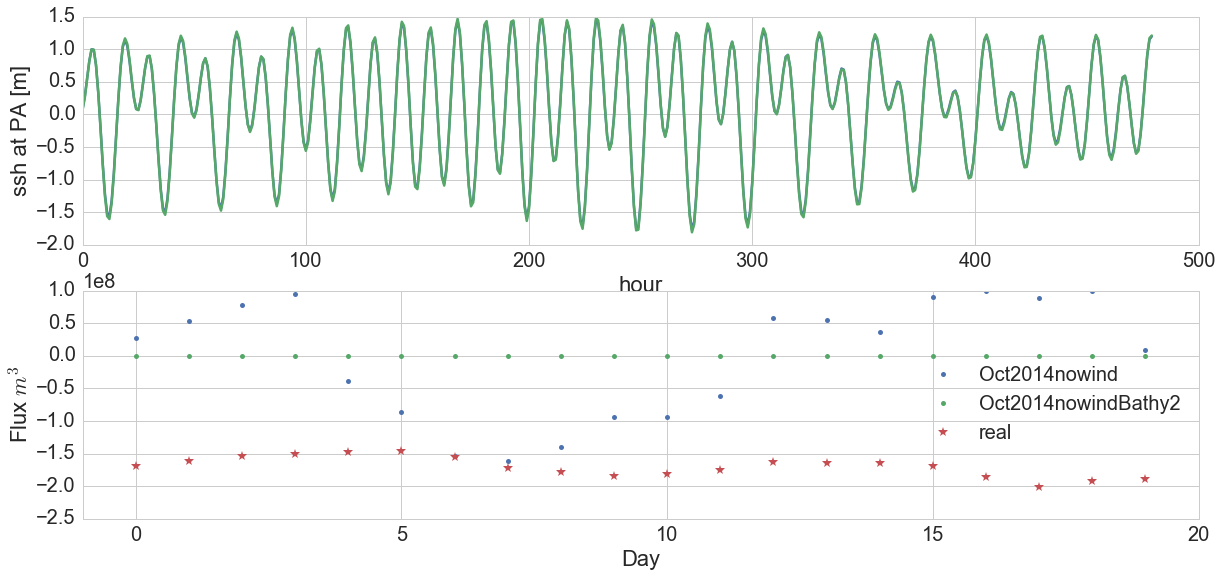

In [15]:
plot_series_transportDaily(S,U,V,ssh,lon,lat,depU,depV,'8',0,479,30,fresh_flag='salt')

# Check at river mouth

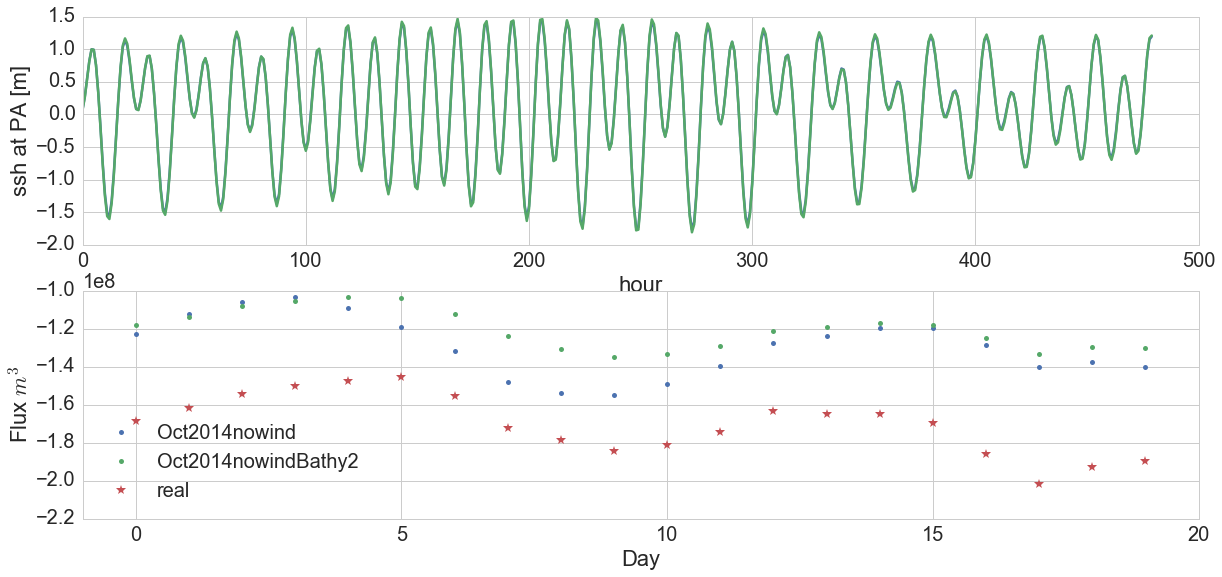

In [16]:
plot_series_transportDaily(S,U,V,ssh,lon,lat,depU,depV,'4',0,479,30,fresh_flag='None')

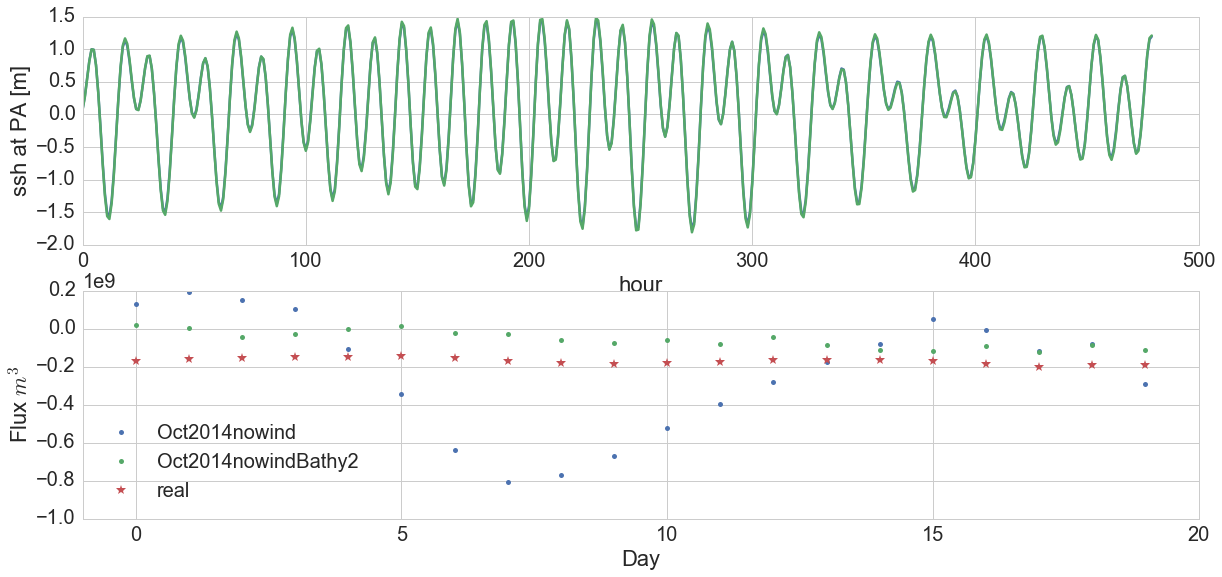

In [17]:
plot_series_transportDaily(S,U,V,ssh,lon,lat,depU,depV,'4',0,479,30,fresh_flag='salt')

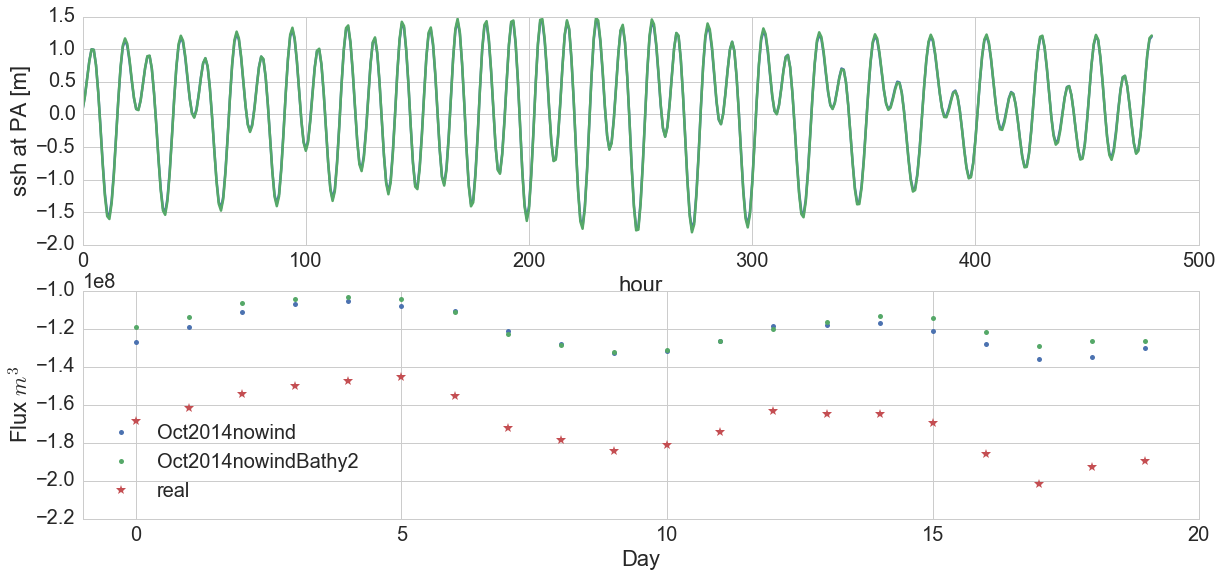

In [18]:
plot_series_transportDaily(S,U,V,ssh,lon,lat,depU,depV,'4',0,479,30,fresh_flag='fresh')

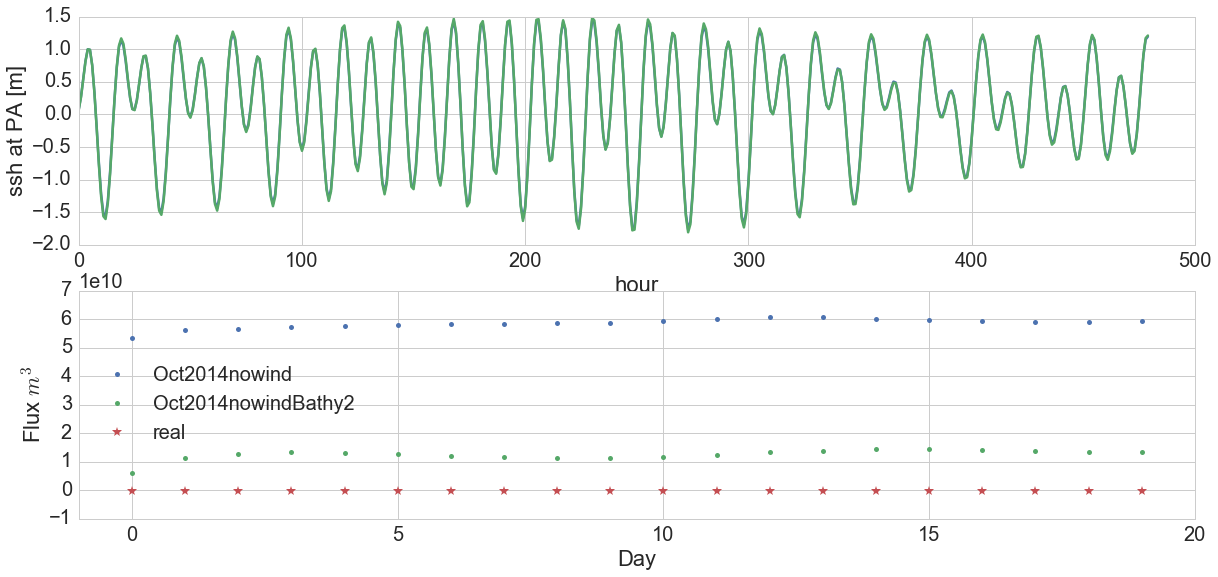

In [19]:
plot_series_transportDaily(S,U,V,ssh,lon,lat,depU,depV,'4',0,479,30,fresh_flag='saltNoV')

look at the hourly variation of volume flux and only salt amount (no times velocity), I didn't expect there is difference between bathy2 and 6 with only river.

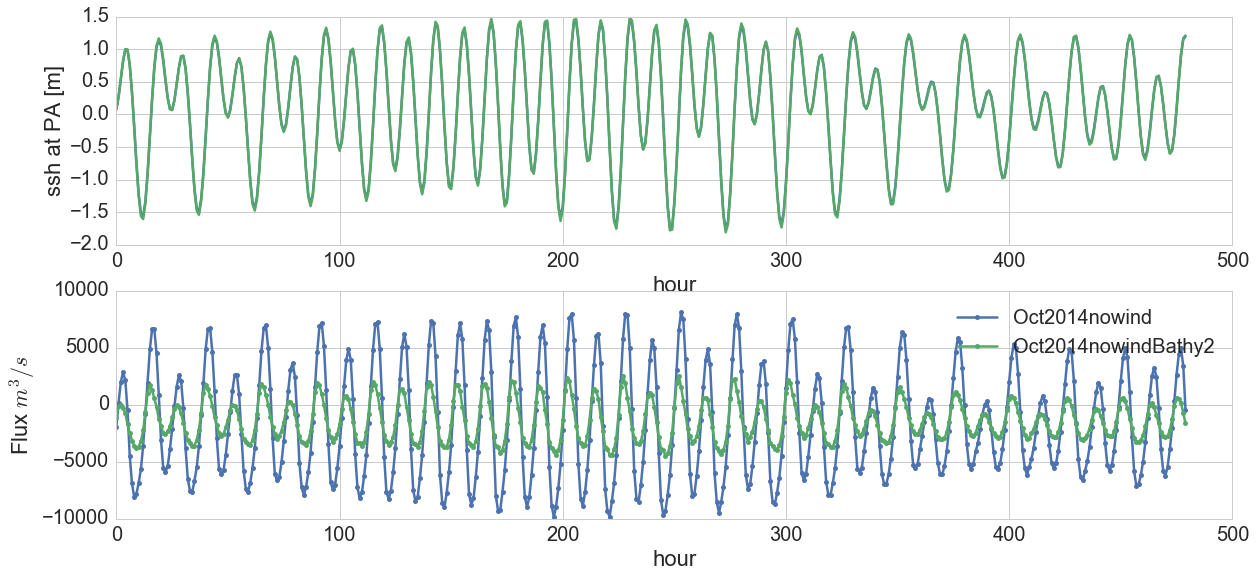

In [20]:
plot_series_transport(S,U,V,ssh,lon,lat,depU,depV,'4',0,479,30,fresh_flag='None')

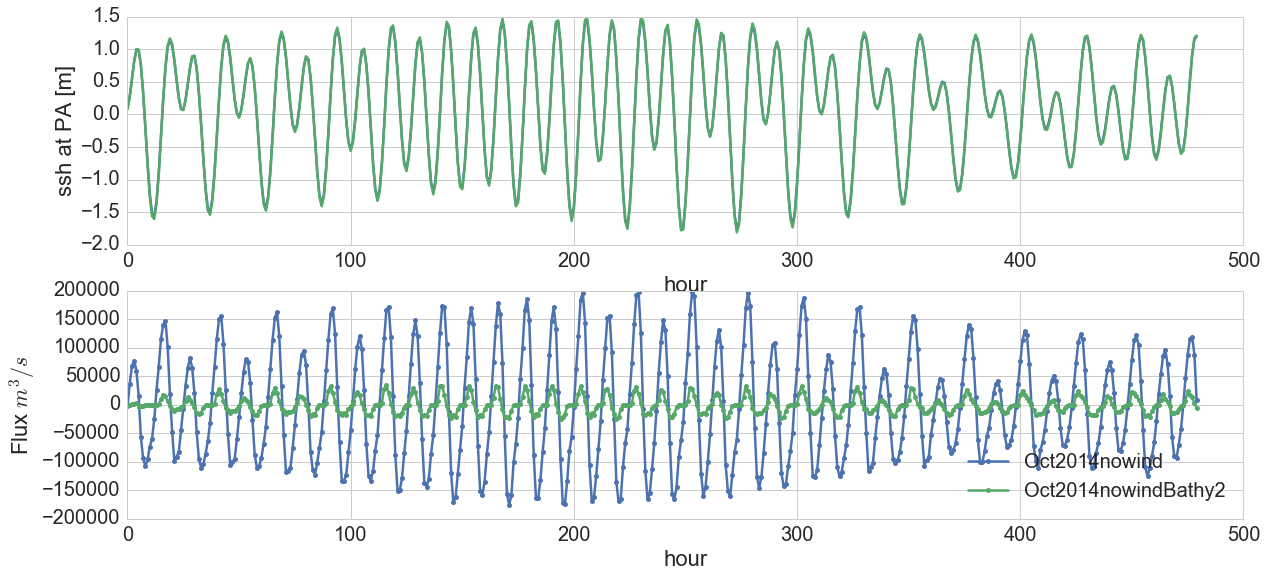

In [21]:
plot_series_transport(S,U,V,ssh,lon,lat,depU,depV,'4',0,479,30,fresh_flag='salt')

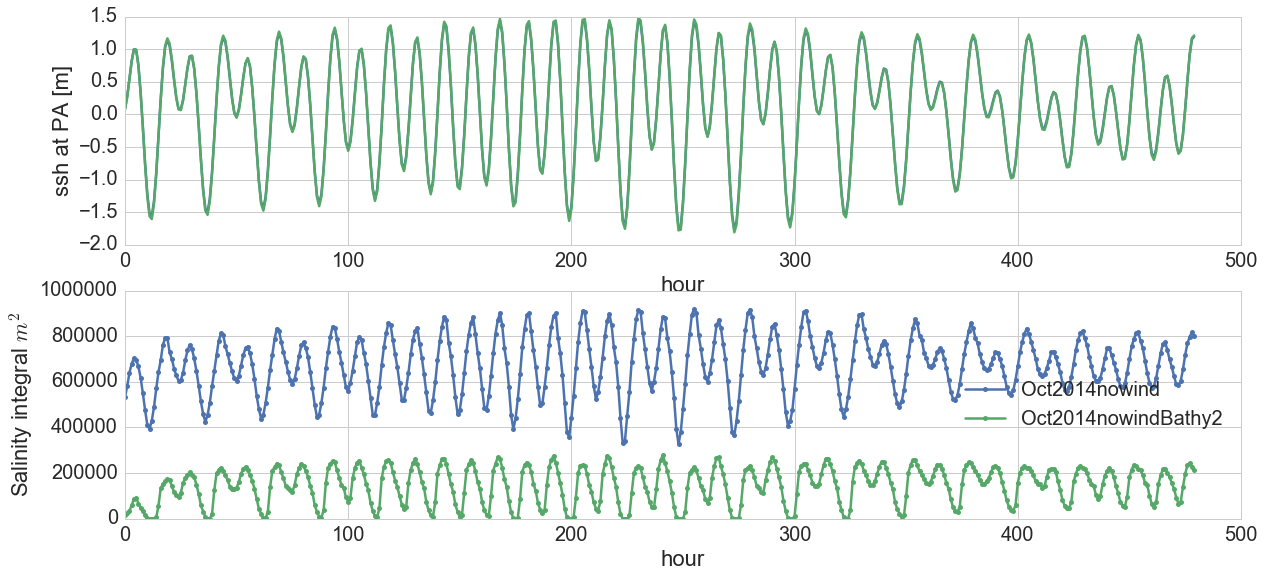

In [22]:
plot_series_transport(S,U,V,ssh,lon,lat,depU,depV,'4',0,479,30,fresh_flag='saltNoV')

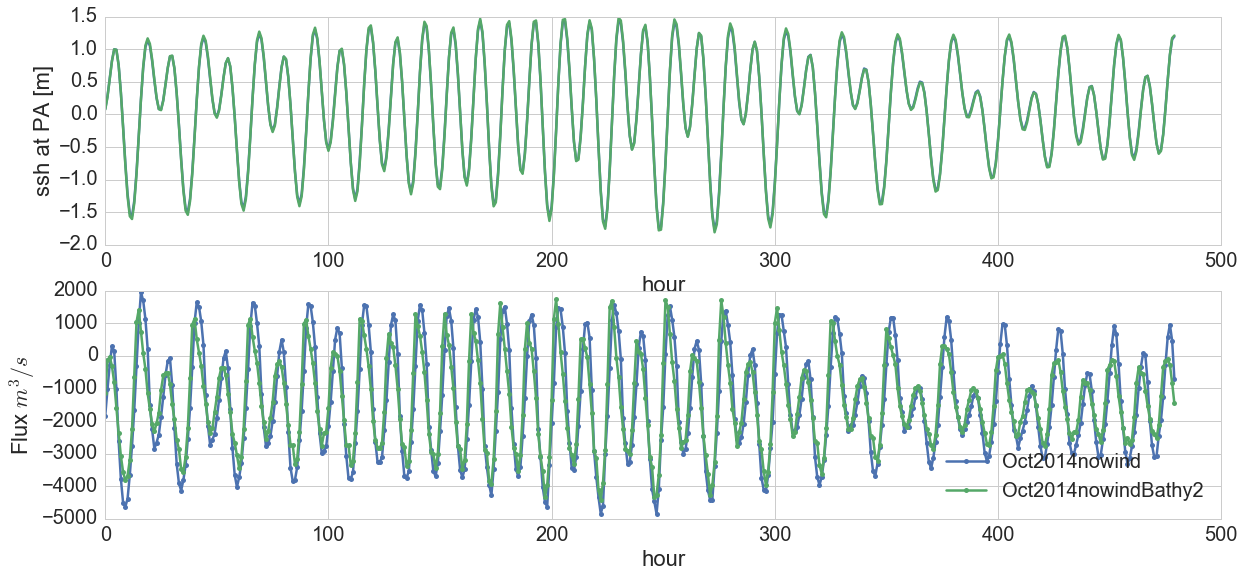

In [23]:
plot_series_transport(S,U,V,ssh,lon,lat,depU,depV,'4',0,479,30,fresh_flag='fresh')

In [62]:
def plot_series_transportDaily_topfour(S,U,V,ssh,lon,lat,depU,depV,tran,tst,ten,S0,fresh_flag = 'fresh'):
    """This function is the same with plot_series_transport, except 
    that this is not integral over several days, but only for 
    daily case."""
    trans,trans_surf,trans_to = transport_calculate(S,U,V,ssh,lon,lat,depU,depV,tran,tst,ten,\
                                                                 S0,fresh_flag = fresh_flag)
    trans_topFour = {};
    for pa in paths:
        trans_topFour[pa] = np.nansum(np.nansum(trans[pa][tst:ten+1,0:5],axis = 1),axis = 1)
    
    inte_trans = {}; types = ['Oct2014nowind','Oct2014nowindBathy2']
    for ty in types:
        inte_trans[ty] = np.zeros((ten+1)/24)
    for i in np.arange(tst,ten+1,24):
        for ty in types:
            inte_trans[ty][i/24] = np.sum(trans_topFour[ty][i:i+24])*3600## intergral individual daily
    fig, axs = plt.subplots(2,1,figsize = (20,9))
    ax = axs[0] ## ssh
    for ty in types:
        ax.plot(ssh[ty][tst:ten+1,86,89],label = ty)
    ax.set_ylabel('ssh at PA [m]')
    ax.set_xlabel('hour')
    ax = axs[1] ## total volumn flux,salt flux and freshwater flux for selected run case and obs
    filename = '/data/dlatorne/SOG-projects/SOG-forcing/ECget/Fraser_flow'
    fraserflow = np.loadtxt(filename)
    real_flows = np.zeros((ten+1)/24);
    for t in np.arange((ten+1)/24): ## default tst -0, from start
        real_flows[t] = -fraserflow[348+t][-1]*24*3600
    for ty in types:
        ax.plot(inte_trans[ty],'.',label = ty,markersize = 10)
        ax.set_ylabel('Flux $m^3$')    
        ax.set_xlim([(tst-24)/24,(ten+1)/24])
    ax.plot(real_flows,'*',label = 'real',markersize = 10)
    ax.legend(loc = 'best')
    ax.set_xlabel('Day')

# check integral over top 4m at river mouth

In [53]:
trans,trans_surf,trans_to=transport_calculate(S,U,V,ssh,lon,lat,depU,depV,'4',0,719,30,fresh_flag='None')

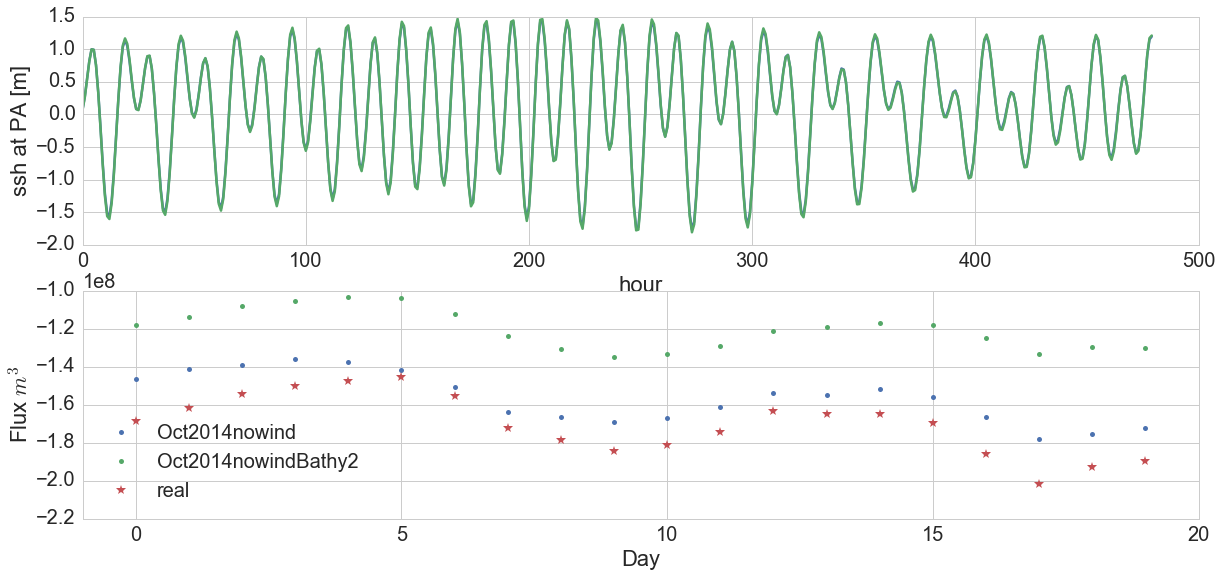

In [63]:
plot_series_transportDaily_topfour(S,U,V,ssh,lon,lat,depU,depV,'4',0,479,30,fresh_flag='None')

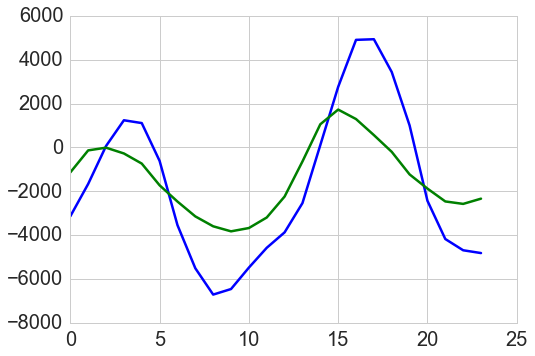

In [90]:
## total flux
plt.plot(np.nansum(np.nansum(trans['Oct2014nowind'][0:24,0:5,:],axis = 1),axis = 1),'b')
plt.plot(np.nansum(np.nansum(trans['Oct2014nowindBathy2'][0:24,0:5,:],axis = 1),axis = 1),'g')

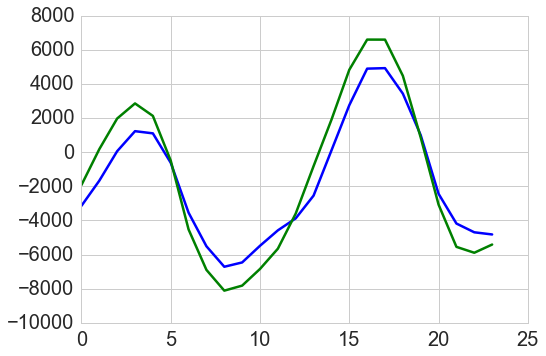

In [86]:
plt.plot(np.nansum(np.nansum(trans['Oct2014nowind'][0:24,0:5,:],axis = 1),axis = 1),'b')
plt.plot(np.nansum(np.nansum(trans['Oct2014nowind'][0:24,:,:],axis = 1),axis = 1),'g')

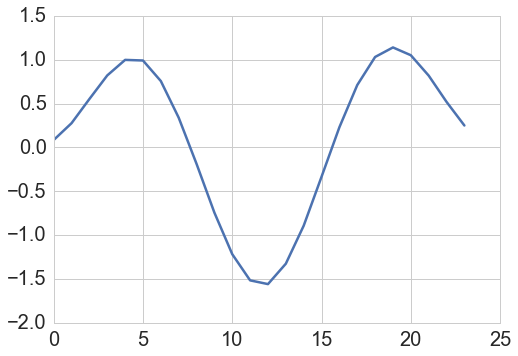

In [89]:
plt.plot(ssh['Oct2014nowind'][0:24,86,89])

In [87]:
np.nansum(np.nansum(trans['Oct2014nowind'][0:24,:,:],axis = 1))

-34089.9499379349

In [88]:
np.nansum(np.nansum(trans['Oct2014nowind'][0:24,0:5,:],axis = 1))

-40674.709969466756

In [92]:
for t in np.arange(0,744,24):
    diff = np.nanmin(np.nansum(np.nansum(trans['Oct2014nowind'][t:t+24,:,:],axis = 1),axis = 1)) - \
    np.nanmin(np.nansum(np.nansum(trans['Oct2014nowind'][t:t+24,0:5,:],axis = 1),axis = 1))
    print(diff/np.nanmin(np.nansum(np.nansum(trans['Oct2014nowind'][t:t+24,:,:],axis = 1),axis = 1)))

0.172650759742
0.162913991986
0.161941596308
0.191875511248
0.208486526815
0.21716565799
0.231531120735
0.230821773155
0.23014532546
0.243525146476
0.221876107198
0.220732282896
0.202027060893
0.173899531948
0.143662433099
0.115275004652
0.116781441581
0.13941979805
0.126463154415
0.13693623887
0.194819211782
0.175130817891
0.206037288649
0.204283040274
0.211317287463
0.221451069995
0.203507795017
0.195371465706
0.178834183184
0.157740988005
nan


# Check integral of volume flux and freshwater over top 4m inside river

In [93]:
trans,trans_surf,trans_to=transport_calculate(S,U,V,ssh,lon,lat,depU,depV,'8',0,719,30,fresh_flag='None')

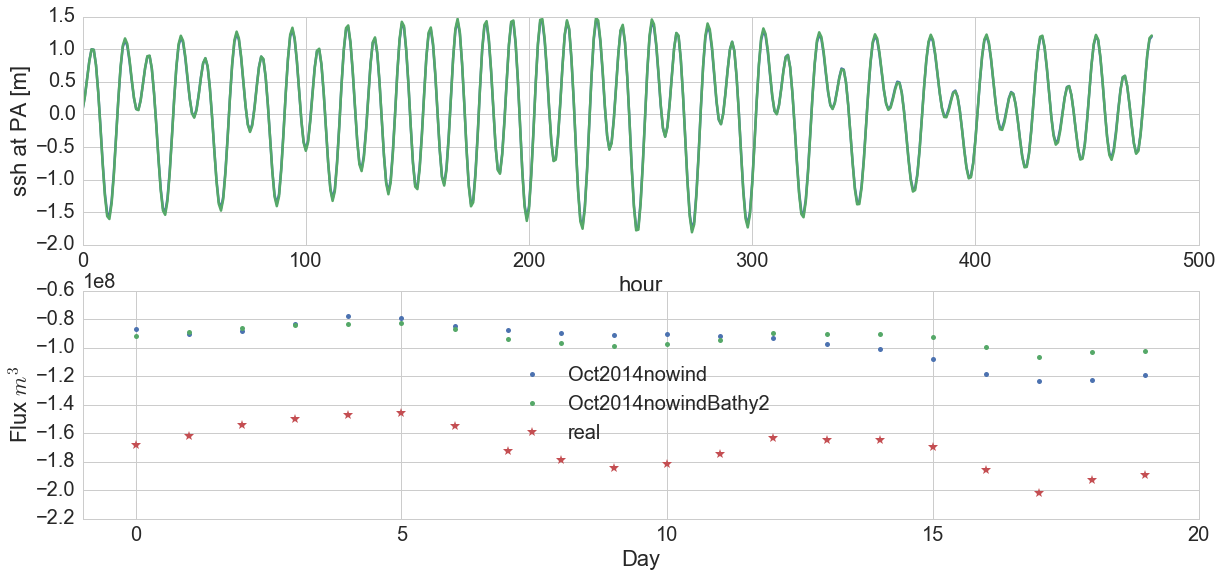

In [96]:
plot_series_transportDaily_topfour(S,U,V,ssh,lon,lat,depU,depV,'8',0,479,30,fresh_flag='None')

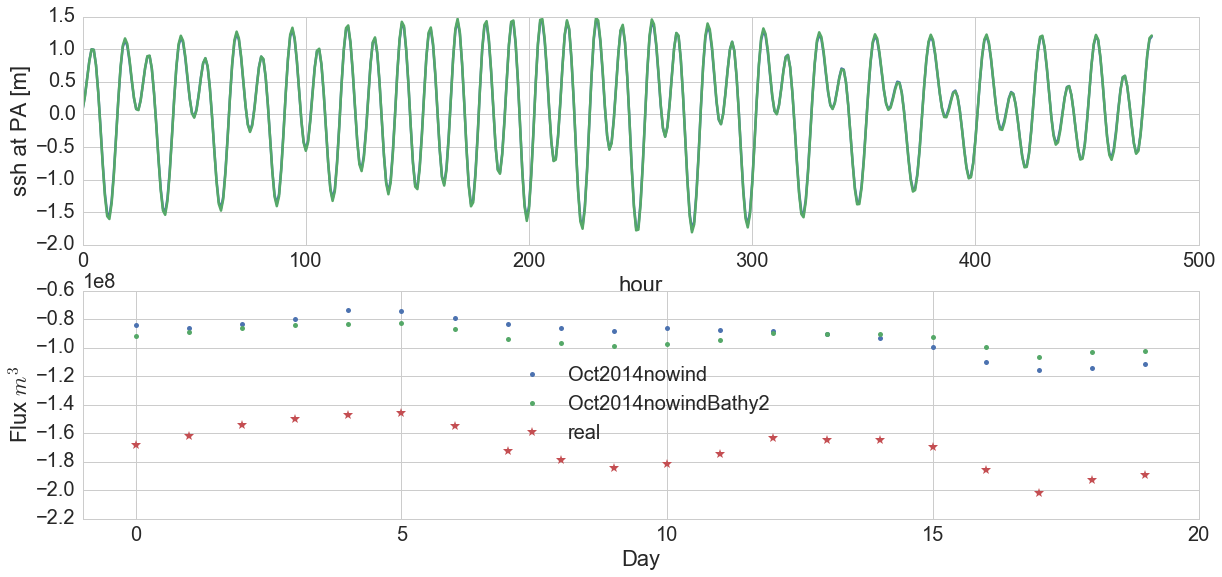

In [97]:
plot_series_transportDaily_topfour(S,U,V,ssh,lon,lat,depU,depV,'8',0,479,30,fresh_flag='fresh')

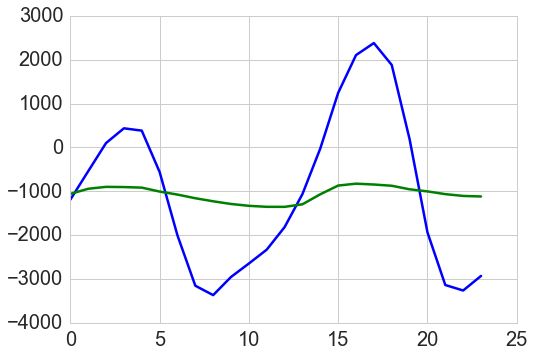

In [94]:
## total flux
plt.plot(np.nansum(np.nansum(trans['Oct2014nowind'][0:24,0:5,:],axis = 1),axis = 1),'b')
plt.plot(np.nansum(np.nansum(trans['Oct2014nowindBathy2'][0:24,0:5,:],axis = 1),axis = 1),'g')

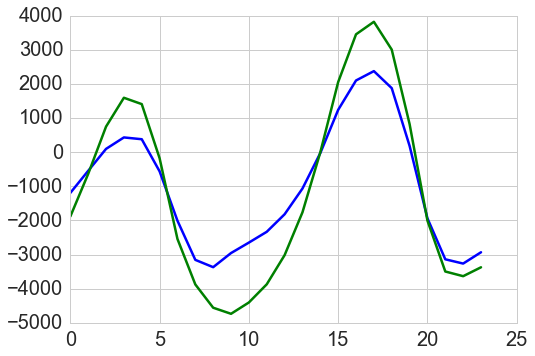

In [95]:
plt.plot(np.nansum(np.nansum(trans['Oct2014nowind'][0:24,0:5,:],axis = 1),axis = 1),'b')
plt.plot(np.nansum(np.nansum(trans['Oct2014nowind'][0:24,:,:],axis = 1),axis = 1),'g')